# Imports and functions

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import mne
import numpy as np
import parse

In /home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/christian/anaconda3/lib/python3.7/site-

In [2]:
def get_clean_data(state, window_length=1.0, sfreq=200.0):
    data_all = []
    ch_names = []
    state_paths = paths / (state + "_AllRegions")
    for path in list(state_paths.glob("*.edf")):
        raw = mne.io.read_raw_edf(str(path), verbose=False)
        ch_names.append([c[:-1] for c in raw.info["ch_names"]])
        
        # BDF is 24 bits anyway, so 64 bits is not necessary
        data_all.append(raw.get_data().astype(np.float32))

        # Sanity check
        assert(sfreq == raw.info["sfreq"])

    data_all = np.vstack(data_all)
    ch_names = np.concatenate(ch_names)

    nb_signals, nb_samples = data_all.shape
    nb_windows = int(nb_samples/sfreq/window_length)
    epochs = np.array(np.hsplit(data_all[:, :int(nb_windows*window_length*sfreq)], 
                                int(nb_samples/(window_length*sfreq))))

    subjects = ch_to_subjects(ch_names)

    epochs_clean_all_subjects = []

    for subject in np.unique(subjects):
        subject_epochs = epochs[:, np.where(subjects == subject)[0], :]

        # zeroed signals of 2s have been inserted at discontinuity. Removing 
        # these zeroed epochs
        x = np.abs(subject_epochs).sum(2)[:, 0]
        assert(len(x[x > 1e-5]) == 60)
        subject_epochs = subject_epochs[x > 1e-5, :, :]

        epochs_clean_all_subjects.append(subject_epochs)

    epochs_clean_all_subjects = np.concatenate(epochs_clean_all_subjects, axis=1)        

    return np.concatenate(epochs_clean_all_subjects, axis=1), ch_names      

def ch_to_subjects(ch_names):
    return np.array([parse.parse("{:l}{:d}{:l}{:w}", ch_name).fixed[1] 
                     for ch_name in ch_names])

def get_dist(name1, name2):
    return np.sqrt(np.sum((channel_info.loc[name1, ["x", "y", "z"]].values - 
                           channel_info.loc[name2, ["x", "y", "z"]].values)**2, axis=1))    

# Setting parameters and loading data

In [3]:
sfreq = 200.0
con_method = "cohy"
state = 'Wakefulness'
window_length=1.0

# The data contain in that repository can be procured here:
# https://mni-open-ieegatlas.research.mcgill.ca/
paths = Path("/media/christian/ElementsSE/intracranial/") 
channel_info = pd.read_csv("/media/christian/ElementsSE/intracranial/information/ChannelInformation.csv",
                          quotechar="'")
patient, electrode = list(zip(*[parse.parse("{:l}{:d}{:l}{:w}", ch_name).fixed 
                                for ch_name in channel_info["Channel name"]]))[1:3]
channel_info["electrode"] = electrode
channel_info = channel_info.set_index("Channel name")

# Computing and saving connectivity

In [4]:
means = []
epochs_con = []

data_clean, ch_names = get_clean_data(state, window_length, sfreq)        
subjects = ch_to_subjects(ch_names)
nb_signals, nb_samples = data_clean.shape
nb_windows = int(nb_samples/sfreq/window_length)
data_clean = data_clean[:, :int(nb_windows*window_length*sfreq)]

# epochs X channels X time
epochs = np.array(np.hsplit(data_clean, nb_windows))  

recompute = False
if recompute or not Path("con_intracranial.npy").exists():
    con, freqs, times, n_epochs, n_tapers = \
        mne.connectivity.spectral_connectivity(epochs, 
                                               method=con_method, 
                                               sfreq=sfreq, verbose=True,
                                               faverage=True, block_size=1000)
    np.save("con_intracranial.npy", con)

con = np.load("con_intracranial.npy")

# Formatting the data as dataframes  

In [5]:
inds = np.tril_indices(nb_signals, k=-1)

ch_name1 = np.ravel(np.tile(ch_names, (nb_signals, 1))[inds])
ch_name2 = np.ravel(np.tile(np.array(ch_names)[:, None], (1, nb_signals))[inds])

subjects1 = ch_to_subjects(ch_name1)    
subjects2 = ch_to_subjects(ch_name2)    

df_between = pd.DataFrame({"con": np.ravel(con[inds])[subjects1 != subjects2],
                           "ch_names1": ch_name1[subjects1 != subjects2], 
                           "ch_names2": ch_name2[subjects1 != subjects2]})
df_between["dist"] = get_dist(df_between.ch_names1.values, df_between.ch_names2.values)
df_between["abs_cohy"] = np.abs(df_between.con)

df_within = pd.DataFrame({"con": np.ravel(con[inds])[subjects1 == subjects2],
                           "ch_names1": ch_name1[subjects1 == subjects2], 
                           "ch_names2": ch_name2[subjects1 == subjects2]})
df_within["dist"] = get_dist(df_within.ch_names1.values, df_within.ch_names2.values)
df_within["abs_cohy"] = np.abs(df_within.con)

# Displaying the average connectivity and exporting the data for further analyses

/home/christian/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christian/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dist', ylabel='abs_cohy'>

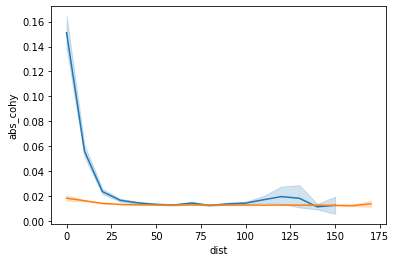

In [6]:
sns.lineplot(np.round(df_within["dist"], -1), df_within["abs_cohy"])
sns.lineplot(np.round(df_between["dist"], -1), df_between["abs_cohy"])

In [7]:
df_within.to_pickle("within_intracranial.pck")
df_between.to_pickle("between_intracranial.pck")